### library 설치

- pip install scikit-learn==1.2.1
- pip install pydotplus==2.0.2
- conda install graphviz

In [1]:
from sklearn import datasets
import warnings
import numpy as np

warnings.filterwarnings('ignore')

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('클래스 레이블:', np.unique(y))

클래스 레이블: [0 1 2]


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [3]:
print('y의 레이블 카운트:', np.bincount(y))
print('y_train의 레이블 카운트:', np.bincount(y_train))
print('y_test의 레이블 카운트:', np.bincount(y_test))

y의 레이블 카운트: [50 50 50]
y_train의 레이블 카운트: [35 35 35]
y_test의 레이블 카운트: [15 15 15]


In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

### 사이킷런으로 퍼셉트론 훈련하기

In [5]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(eta0=0.1, random_state=1)

In [6]:
y_pred = ppn.predict(X_test_std)
print('잘못 분류된 샘플 개수: %d' % (y_test != y_pred).sum())

잘못 분류된 샘플 개수: 1


In [7]:
from sklearn.metrics import accuracy_score

print('정확도: %.3f' % accuracy_score(y_test, y_pred))

정확도: 0.978


In [8]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # 마커와 컬러맵을 설정합니다.
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 결정 경계를 그립니다.
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, 
                    edgecolor='black')

    # 테스트 샘플을 부각하여 그립니다.
    if test_idx:
        # 모든 샘플을 그립니다.
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0], X_test[:, 1],
                    facecolor='none', edgecolor='black', alpha=1.0,
                    linewidth=1, marker='o',
                    s=100, label='test set')

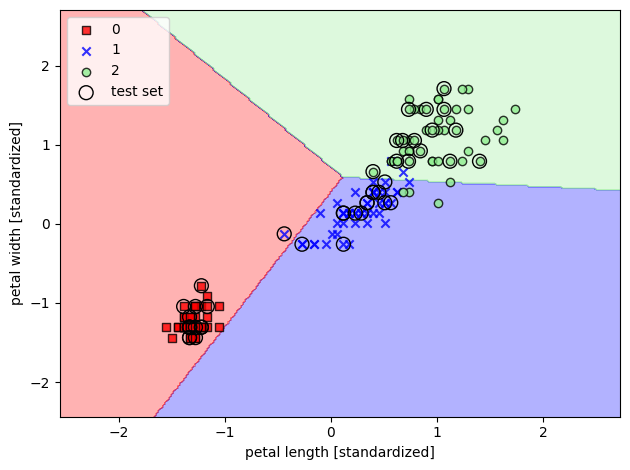

In [9]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined_std, 
                      y=y_combined,
                      classifier=ppn, 
                      test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 결정 트리 학습

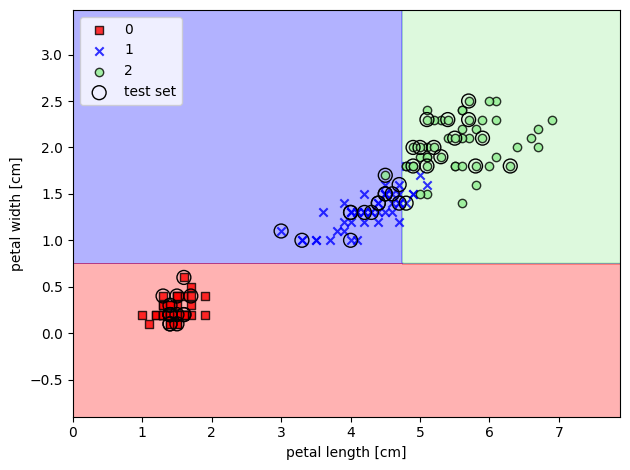

In [52]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=2, random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, 
                      y_combined, 
                      classifier=tree,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 결정 트리 시각화

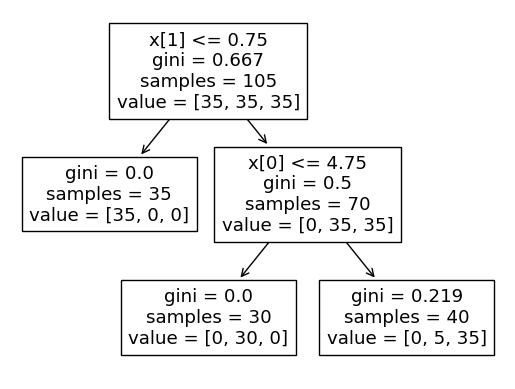

In [53]:
from sklearn import tree as t

t.plot_tree(tree)
plt.show()

In [56]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 

graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

True

### 결정 트리 평가

In [55]:
from sklearn.metrics import accuracy_score

y_tree_pred_train = tree.predict(X_train)
print('(학습) 잘못 분류된 샘플 개수: %d' % (y_train != y_tree_pred_train).sum())
print('(학습) 정확도: %.3f' % accuracy_score(y_train, y_tree_pred_train))

y_tree_pred = tree.predict(X_test)
print('(테스트) 잘못 분류된 샘플 개수: %d' % (y_test != y_tree_pred).sum())
print('(테스트) 정확도: %.3f' % accuracy_score(y_test, y_tree_pred))

(학습) 잘못 분류된 샘플 개수: 5
(학습) 정확도: 0.952
(테스트) 잘못 분류된 샘플 개수: 2
(테스트) 정확도: 0.956


### 하이퍼파라미터 영향 점검

In [14]:
# 결정 트리 학습
def train(X_train, y_train, X_test, y_test, max_depth=None):
    tree_model = DecisionTreeClassifier(criterion='gini', 
                                        max_depth=max_depth,
                                        random_state=1)
    
    tree_model.fit(X_train, y_train)
    
    # 성능 측정
    y_tree_pred_train = tree_model.predict(X_train)
    print('(학습) 잘못 분류된 샘플 개수: %d' % (y_train != y_tree_pred_train).sum())
    print('(학습) 정확도: %.3f' % accuracy_score(y_train, y_tree_pred_train))

    y_tree_pred = tree_model.predict(X_test)
    print('(테스트) 잘못 분류된 샘플 개수: %d' % (y_test != y_tree_pred).sum())
    print('(테스트) 정확도: %.3f' % accuracy_score(y_test, y_tree_pred))

    return tree_model

# 결정 트리 시각화
def tree_visualization(tree_model, filename):    
    tree.plot_tree(tree_model)
    plt.show()
    
    dot_data = export_graphviz(tree_model,
                               filled=True, 
                               rounded=True,
                               class_names=['Setosa', 
                                            'Versicolor',
                                            'Virginica'],
                               feature_names=['petal length', 
                                              'petal width'],
                           out_file=None) 
    graph = graph_from_dot_data(dot_data) 
    graph.write_png(filename) 

(학습) 잘못 분류된 샘플 개수: 5
(학습) 정확도: 0.952
(테스트) 잘못 분류된 샘플 개수: 2
(테스트) 정확도: 0.956


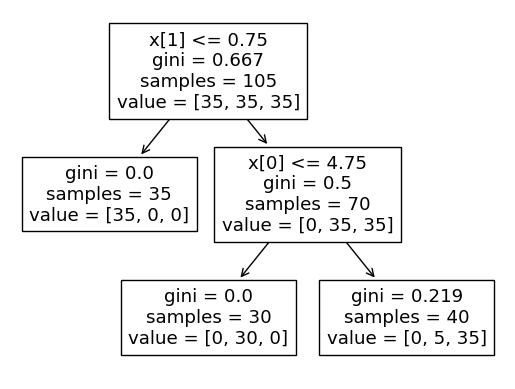

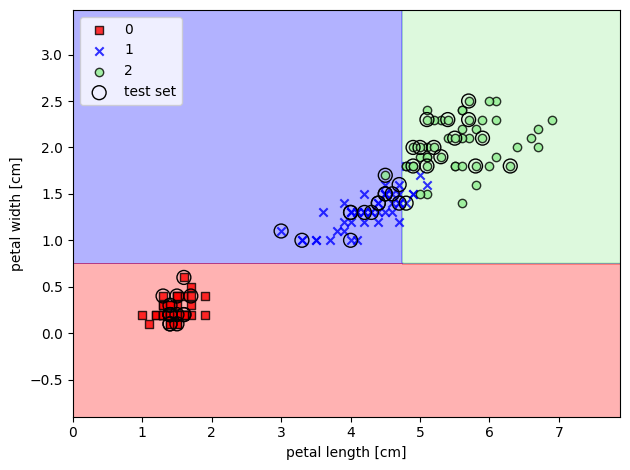

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt

# 하이퍼 파라미터 변경
max_depth = 2

# 결정 트리 학습 및 성능 측정
tree_model = train(X_train, y_train, X_test, y_test, max_depth=max_depth)

# 트리 모양 시각화
tree_visualization(tree_model, "tree_depth3.png")

# 결정 경계 시각화
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, 
                      y_combined, 
                      classifier=tree_model,
                      test_idx=range(105, 150))
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
from sklearn.model_selection import cross_val_score

tree_model_depth1 = DecisionTreeClassifier(criterion='gini', 
                                           max_depth=1,
                                           random_state=1)
tree_model_depth3 = DecisionTreeClassifier(criterion='gini', 
                                           max_depth=3,
                                           random_state=1)

scores_depth1 = cross_val_score(estimator=tree_model_depth1, X=X_train, y=y_train, cv=10)
scores_depth3 = cross_val_score(estimator=tree_model_depth3, X=X_train, y=y_train, cv=10)

print("Decision Tree (depth=1) - ACC:  %0.2f (+/- %0.2f)" % (scores_depth1.mean(), scores_depth1.std()))
print("Decision Tree (depth=3) - ACC:  %0.2f (+/- %0.2f)" % (scores_depth3.mean(), scores_depth3.std()))

print()
print(scores_depth1)
print(scores_depth3)

Decision Tree (depth=1) - ACC:  0.62 (+/- 0.02)
Decision Tree (depth=3) - ACC:  0.92 (+/- 0.07)

[0.63636364 0.63636364 0.63636364 0.63636364 0.63636364 0.6
 0.6        0.6        0.6        0.6       ]
[1.         1.         1.         0.90909091 0.81818182 1.
 0.8        0.9        0.9        0.9       ]


In [46]:
from scipy.stats import ttest_rel

result = ttest_rel(a=scores_depth1, b=scores_depth3)
print(result)
print('(Statistically) significantly different: %s' % (result.pvalue < 0.05))

TtestResult(statistic=-13.376241116062463, pvalue=3.0383768569963356e-07, df=9)
(Statistically) significantly different: True
